In [5]:
import argparse
import urllib
import gzip
import shutil
import pandas as pd
import numpy as np
import logging
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf
import os
import matplotlib.pyplot as plt

In [6]:
# from google.colab import drive
# drive.mount('/content/drive')

In [7]:
data = pd.read_csv('/content/drive/MyDrive/Dataset/MoleculeSythesis/dataset/AA.csv')
data = data[:250000]

In [8]:
df1 = pd.read_csv('/content/drive/MyDrive/Dataset/MoleculeSythesis/dataset/AA.csv')
df2 = pd.read_csv('/content/drive/MyDrive/Dataset/MoleculeSythesis/BJ.csv')
data = pd.concat([df1, df2])
data = data.sample(frac=1).reset_index(drop=True)
data = data[:250000]
data.head(25)

,zinc_id,smiles
0,ZINC000117053873,C/C(=C\CC1CCCCCCCCC1)C(=O)O
1,ZINC000038034639,Cc1noc(CNC[C@H](O)CO)n1
2,ZINC000213110151,N[C@H](COC[C@H](O)CO)C(=O)O
3,ZINC000691458499,CCCCCCCCCC1(CN)CC(C)C1
4,ZINC000307621149,CC(=O)N(C)CC(=O)NO
5,ZINC000020687759,O=C1C(=O)N(O)[C@@H]2CO[C@H]12
6,ZINC000198876095,CC(C)=CC/C=C(C)\C=C/O[Si](C)(C)C
7,ZINC001459398562,CC[C@H](c1ccccc1)N(CC)CCCC1CC1
8,ZINC001653295318,CC(C)C[C@H]1CCCN1C[C@@H](C)CC(C)(C)C
9,ZINC000104634531,NC(=O)C(CCO)C(N)=O


In [9]:
data['smiles'].apply(len).max()

80

In [10]:
smiles_data = data['smiles'][:250000]
smiles_data = np.array(smiles_data).reshape(-1)
print('Number of mols: '+str(len(smiles_data)))
idx = [i for i, x in enumerate(smiles_data) if len(x)<=120]
print('Number of valid mols: '+str(len(idx)))
smiles_data = smiles_data[idx]
print('Getting a unique character set...')

Number of mols: 250000
Number of valid mols: 250000
Getting a unique character set...


In [11]:
char_set = set()
for i in tqdm(range(len(smiles_data))):
    smiles_data[i] = smiles_data[i].ljust(62)
    char_set = char_set.union(set(smiles_data[i]))
char_set_list = sorted(list(char_set))
print('Number of characters: '+str(len(char_set_list)))

100%|██████████| 250000/250000 [00:00<00:00, 387194.31it/s]

Number of characters: 37


In [12]:
len(char_set_list)

37

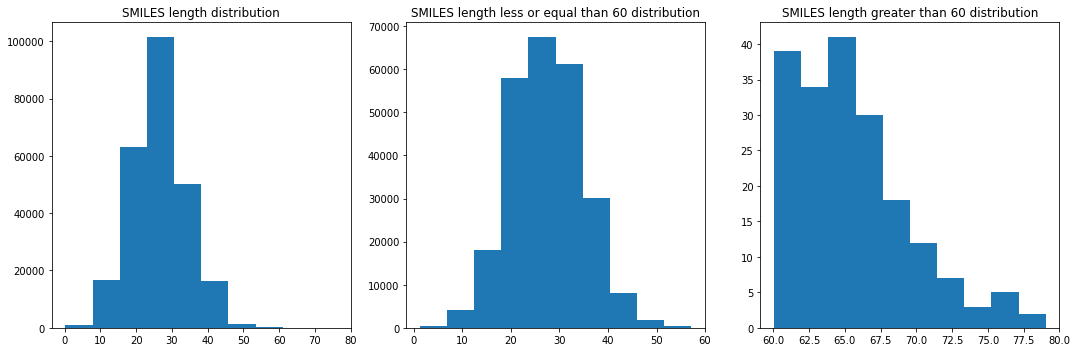

In [13]:
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (15, 5))
axes[0].set_title("SMILES length distribution")
axes[0].hist(data['smiles'].str.len(), align = 'left')
axes[1].set_title("SMILES length less or equal than 60 distribution")
axes[1].hist(data[data['smiles'].str.len() <= 60]['smiles'].str.len(), align = 'left')
axes[2].set_title("SMILES length greater than 60 distribution")
axes[2].hist(data[data['smiles'].str.len() > 60]['smiles'].str.len(), align = 'left')
fig.tight_layout()

plt.show()

In [14]:
print("SMILES max length: {0}".format(data['smiles'].str.len().max()))
print("SMILES min length: {0}".format(data['smiles'].str.len().min()))
print("Number of SMILES with length less or equal than 60: {0}".format(len(data[data['smiles'].str.len() <= 60])))
print("Number of SMILES with length grather than 60: {0}".format(len(data[data['smiles'].str.len() > 60])))

SMILES max length: 80
SMILES min length: 4
Number of SMILES with length less or equal than 60: 249809
Number of SMILES with length grather than 60: 191


In [15]:
# Charset Sanity Check
charset = []
for smile in tqdm(data['smiles'], total = len(data['smiles'])):
    for c in smile:
        if c not in charset:
            charset.append(c)

isbreak = False
for l in char_set_list:
    if l not in charset:
        isbreak = True
        break

if not isbreak:
    print("The vocabulary CHARSET contain all needed characters.")
else:
    print("The vocabulary CHARSET does not contain all needed characters.")

100%|██████████| 250000/250000 [00:01<00:00, 162656.67it/s]

The vocabulary CHARSET does not contain all needed characters.


In [16]:
encoder_dict =   dict((c,i) for i,c in enumerate(charset))
decoder_dict =   dict((i,c) for i,c in enumerate(charset))

def one_hot_encoder(smiles, length = 78):
  X = np.zeros((length, len(charset)))
  for i, c in enumerate( smiles ):
    X[i, encoder_dict[c]] = 1
    return X

def one_hot_decoder(X):
  smi = ''
  X = X.argmax( axis=-1 )
  for i in X:
    smi += decoder_dict[i]
  return smi
print(encoder_dict)
print(decoder_dict)

{'C': 0, '/': 1, '(': 2, '=': 3, '\\': 4, '1': 5, ')': 6, 'O': 7, 'c': 8, 'n': 9, 'o': 10, 'N': 11, '[': 12, '@': 13, 'H': 14, ']': 15, '2': 16, 'S': 17, 'i': 18, 'l': 19, 'F': 20, '3': 21, '+': 22, '-': 23, 's': 24, '#': 25, 'P': 26, 'B': 27, '4': 28, 'r': 29, 'p': 30, '5': 31, '8': 32, '7': 33, '6': 34, 'I': 35}
{0: 'C', 1: '/', 2: '(', 3: '=', 4: '\\', 5: '1', 6: ')', 7: 'O', 8: 'c', 9: 'n', 10: 'o', 11: 'N', 12: '[', 13: '@', 14: 'H', 15: ']', 16: '2', 17: 'S', 18: 'i', 19: 'l', 20: 'F', 21: '3', 22: '+', 23: '-', 24: 's', 25: '#', 26: 'P', 27: 'B', 28: '4', 29: 'r', 30: 'p', 31: '5', 32: '8', 33: '7', 34: '6', 35: 'I'}


In [18]:
x_train_encoded = []
x_train_decoded = []
for item in data['smiles']:
  x_train_encoded.append(one_hot_encoder(item))
for item in x_train_encoded:
  x_train_decoded.append(one_hot_decoder(item))
x_train_encoded = np.array(x_train_encoded)
# x_train_decoded = np.array(x_train_decoded)
print(x_train_encoded.shape)
# print(x_train_decoded.shape)

(250000, 78, 36)


In [19]:
x_train_encoded = x_train_encoded.reshape(-1,78,36,1)
x_train_encoded.shape

(250000, 78, 36, 1)

In [20]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
import matplotlib.patches as mpatches 
%matplotlib inline
from scipy.stats import norm 
import keras
from keras import layers
from keras.models import Model 
from keras import metrics
from keras import backend as K 
K.clear_session()
np.random.seed(237)
import scipy.stats as st
import tensorflow.compat.v1.keras.backend as K 
import tensorflow as tf 
tf.compat.v1.disable_eager_execution()
from tensorflow.keras.optimizers import Adam 
import warnings 
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
import numpy as np
from scipy.stats import multivariate_normal

In [21]:
def sampling(args):
  z_mu, z_log_sigma = args
  epsilon = K.random_normal(shape=(K.shape(z_mu)[0], latent_dim),
  mean=0., stddev=1.)
  return z_mu + K.exp(z_log_sigma) * epsilon

In [37]:
img_shape = (78, 36, 1)
batch_size = 64
latent_dim = 2
input_img = tf.keras.Input(shape=img_shape)

# x = layers.Conv1D(16, 7,
#                   strides = 1)(input_img)
# x = layers.BatchNormalization()(x)
# x = layers.Activation('relu')(x)

x = layers.Conv1D(32, 7,
                  strides = 1)(input_img)
x = layers.BatchNormalization(momentum = 0.5)(x)
# x = layers.Activation('relu')(x)
x = layers.LeakyReLU(alpha=0.3)(x)

x = layers.Conv1D(64, 7,
                  strides = 1)(x)
x = layers.BatchNormalization(momentum = 0.5)(x)
# x = layers.Activation('relu')(x)
x = layers.LeakyReLU(alpha=0.3)(x)

x = layers.Conv1D(128, 7,
                  
                  strides = 1)(x)
x = layers.BatchNormalization(momentum = 0.5)(x)
# x = layers.Activation('relu')(x)
x = layers.LeakyReLU(alpha=0.3)(x)

# x = layers.Dense(512)(x)
# x = layers.BatchNormalization()(x)
# x = layers.Activation('relu')(x)

# x = layers.Dense(1024)(x)
# x = layers.BatchNormalization()(x)
# x = layers.Activation('relu')(x)


shape_before_flattening = K.int_shape(x)
x = layers.Flatten()(x)
z_mu = layers.Dense(latent_dim)(x)
z_log_sigma = layers.Dense(latent_dim)(x)
z = layers.Lambda(sampling)([z_mu, z_log_sigma])

encoder = tf.keras.Model(input_img,[z_mu,z_log_sigma])
encoder.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 78, 36, 1)]  0                                            
__________________________________________________________________________________________________
conv1d_4 (Conv1D)               (None, 78, 30, 32)   256         input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_9 (BatchNor (None, 78, 30, 32)   128         conv1d_4[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 78, 30, 32)   0           batch_normalization_9[0][0]      
____________________________________________________________________________________________

In [38]:
decoder_input = layers.Input(K.int_shape(z)[1:])
x = layers.Dense(np.prod(shape_before_flattening[1:]),activation='relu')(decoder_input)
#Decoder
x = layers.Dense(512)(x)
x = layers.BatchNormalization(momentum = 0.9)(x)
# x = layers.Activation('relu')(x)
x = layers.LeakyReLU(alpha=0.3)(x)

x = layers.RepeatVector(78)(x)

x = tf.compat.v1.keras.layers.CuDNNGRU(512, return_sequences=True)(x)
x = layers.BatchNormalization(momentum = 0.9)(x)

# x = tf.compat.v1.keras.layers.CuDNNGRU(512, return_sequences=True)(x)
# x = layers.BatchNormalization()(x)

# x = tf.compat.v1.keras.layers.CuDNNGRU(512, return_sequences=True)(x)
# x = layers.BatchNormalization()(x)

x = tf.compat.v1.keras.layers.CuDNNGRU(512, return_sequences=True)(x)

outputs_logits = layers.TimeDistributed(layers.Dense(36))(x)
x = layers.Activation('tanh')(outputs_logits)

In [39]:
decoder = Model(decoder_input, x)
z_decoded = decoder(z)

In [40]:
decoder.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_12 (Dense)             (None, 179712)            539136    
_________________________________________________________________
dense_13 (Dense)             (None, 512)               92013056  
_________________________________________________________________
batch_normalization_12 (Batc (None, 512)               2048      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 78, 512)           0         
_________________________________________________________________
cu_dnngru_4 (CuDNNGRU)       (None, 78, 512)           1575

In [41]:
class CustomVariationalLayer(keras.layers.Layer):
    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        xent_loss = keras.metrics.binary_crossentropy(x, z_decoded) #Recin loss
        kl_loss = -5e-4 * K.mean(1 + z_log_sigma - K.square(z_mu) - K.exp(z_log_sigma), axis=-1) #KL loss
        return K.mean(xent_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        return x

y = CustomVariationalLayer()([input_img, z_decoded])

In [42]:
# VAE model statement
vae = Model(input_img, y)
vae.compile(optimizer='rmsprop', loss=None)
vae.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 78, 36, 1)]  0                                            
__________________________________________________________________________________________________
conv1d_4 (Conv1D)               (None, 78, 30, 32)   256         input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_9 (BatchNor (None, 78, 30, 32)   128         conv1d_4[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 78, 30, 32)   0           batch_normalization_9[0][0]      
____________________________________________________________________________________________

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)
vae.fit(x = x_train_encoded[:20000], y=None,
        shuffle=True,
        epochs=20,
        batch_size=16,callbacks=[callback]
)

Train on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 47s 2ms/sample - loss: 29953058739123.5938
Epoch 2/20
20000/20000 [==============================] - 40s 2ms/sample - loss: 513816.9644
Epoch 3/20
20000/20000 [==============================] - 40s 2ms/sample - loss: 3757464982.8651
Epoch 4/20
20000/20000 [==============================] - 40s 2ms/sample - loss: 551.6626
Epoch 5/20
20000/20000 [==============================] - 40s 2ms/sample - loss: 74533595709356976.0000
Epoch 6/20
20000/20000 [==============================] - 40s 2ms/sample - loss: 11535052078423.0762
Epoch 7/20
20000/20000 [==============================] - 40s 2ms/sample - loss: 48306344956552784.0000
Epoch 8/20
20000/20000 [==============================] - 40s 2ms/sample - loss: 124201858769.8021
Epoch 9/20
20000/20000 [==============================] - 40s 2ms/sample - loss: 32678621065.5142
Epoch 10/20
20000/20000 [==============================] - 40s 2ms/sample - loss: 65263449

In [1]:
sample_vector = np.array([[0,5]])
result = decoder.predict(sample_vector)

NameError: ignored

In [2]:
result.shape

NameError: ignored

In [ ]:
result = result[0].reshape(78, 36)

In [ ]:
result.shape

In [ ]:
one_hot_decoder(result)

In [ ]:
def get_loss(distribution_mean, distribution_variance):
    
    def get_reconstruction_loss(y_true, y_pred):
        reconstruction_loss = tf.keras.losses.mse(y_true, y_pred)
        reconstruction_loss_batch = tf.reduce_mean(reconstruction_loss)
        return reconstruction_loss_batch*28*28
    
    def get_kl_loss(distribution_mean, distribution_variance):
        kl_loss = 1 + distribution_variance - tf.square(distribution_mean) - tf.exp(distribution_variance)
        kl_loss_batch = tf.reduce_mean(kl_loss)
        return kl_loss_batch*(-0.5)
    
    def total_loss(y_true, y_pred):
        reconstruction_loss_batch = get_reconstruction_loss(y_true, y_pred)
        kl_loss_batch = get_kl_loss(distribution_mean, distribution_variance)
        return reconstruction_loss_batch + kl_loss_batch
    
    return total_loss

In [ ]:
vae.compile(loss=get_loss(z_mu, z_log_sigma), optimizer='adam')
vae.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 60, 36, 1)]  0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 60, 30, 32)   256         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 60, 30, 32)   128         conv1d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 60, 30, 32)   0           batch_normalization[0][0]        
____________________________________________________________________________________________

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)
vae.fit(x = x_train_encoded[:20000], y=None,
        shuffle=True,
        epochs=20,
        batch_size=200,callbacks=[callback]
)

Train on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 22s 1ms/sample - loss: nan
Epoch 2/20
20000/20000 [==============================] - 16s 796us/sample - loss: nan
Epoch 3/20
20000/20000 [==============================] - 16s 793us/sample - loss: nan
Epoch 4/20
20000/20000 [==============================] - 16s 798us/sample - loss: nan
Epoch 5/20
20000/20000 [==============================] - 16s 795us/sample - loss: nan
Epoch 6/20
20000/20000 [==============================] - 16s 795us/sample - loss: nan
Epoch 7/20
20000/20000 [==============================] - 16s 794us/sample - loss: nan
Epoch 8/20
20000/20000 [==============================] - 16s 795us/sample - loss: nan
Epoch 9/20
20000/20000 [==============================] - 16s 793us/sample - loss: nan
Epoch 10/20
20000/20000 [==============================] - 16s 794us/sample - loss: nan
